In [1]:
# ANALISI SHAP DATASET DI TEST TOTALE, VISUALIZZAZIONE DIVISA PER IMPATTO SU CLASSE 0 E 1


In [ ]:
# levare dalla visualizzazione dei grafici le parole chiave con cui hanno fatto retreiving del tweet

In [11]:
import torch
from transformers import AutoTokenizer

import shap
import nltk
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from error_analysis_TRC import load_local_model
from TRC.utils import create_token_dict, get_top_n, load_local_TRC_model


from better_profanity import profanity
from copy import deepcopy
from ast import literal_eval

In [12]:
# ASSIGN_WEIGHT = True

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# #device = "cpu"
# #model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'
# model_name = 'microsoft/deberta-v3-large'

# model_path = '/mnt/c/Users/auror/Desktop/deberta-v3-large-tweet-fid-TRC/pytorch_model.bin'
# config_path = '/mnt/c/Users/auror/Desktop/deberta-v3-large-tweet-fid-TRC/config.json'


In [13]:
# tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
# model = load_local_TRC_model(model_path, config_path, device, model_name)
# model = model.to(device)

In [4]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [14]:
# explainer = shap.Explainer(f, masker = tokenizer)
# explainer

In [15]:
# df_errati = pd.read_csv('/home/agensale/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_errati.csv', index_col = 0, converters={'Tweet tok':literal_eval})
# df_corretti = pd.read_csv('/home/agensale/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_corretti.csv', index_col=0,  converters={'Tweet tok':literal_eval})
# df_total = pd.concat([df_errati, df_corretti])

# df_errati = pd.read_csv('/mnt/c/Users/auror/Desktop/rora_tesi_new/log/log_TRC/deberta-v3-large/tweet_errati.csv', index_col = 0, converters={'Tweet tok':literal_eval})
# df_corretti = pd.read_csv('/mnt/c/Users/auror/Desktop/rora_tesi_new/log/log_TRC/deberta-v3-large/tweet_corretti.csv', index_col=0,  converters={'Tweet tok':literal_eval})
# df_total = pd.concat([df_errati, df_corretti])

In [58]:
# df_total.head()

In [11]:
# df_pred_1 = df_total[(df_total['Pred label'] == 1 )]
# df_pred_1 = df_pred_1.reset_index()
# df_pred_0 = df_total[(df_total['Pred label'] == 0 )]
# df_pred_0 = df_pred_0.reset_index()

In [12]:
# tweet_pred_1 = df_pred_1['Tweet'].values.tolist()
# tweet_pred_0 = df_pred_0['Tweet'].values.tolist()

In [13]:
# tokens_pred_1 = df_pred_1['Tweet tok'].tolist()
# tokens_pred_0 = df_pred_0['Tweet tok'].tolist()

In [7]:
def clean_strings(big_tokens_list):
    tags = ['@USER','USER', 'HTTPURL', 'HTTP', 'URL']
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    clean_list = []
    for t_list in big_tokens_list:
        tokens = deepcopy(t_list)
        for token, i in zip(t_list, range(len(t_list))):
            tmp = deepcopy(token)
            tmp = tmp.strip()
            tmp = tmp.lower()
            if tmp in string.punctuation or \
            tmp.upper() in tags or \
            tmp == '...' or  tmp == '....' or \
            tmp in stop_words or \
            profanity.contains_profanity(tmp) or \
            len(tmp) < 3:
                tokens.remove(token)
        clean_list.append(' '.join(tokens))
    return clean_list
        

In [13]:
# clean_pred_1 = clean_strings(tokens_pred_1)
# clean_pred_0 = clean_strings(tokens_pred_0)

In [14]:
# SHAP FOR ALL DS

In [8]:
# all_tweets = df_total['Tweet'].tolist()
all_tweets_tokens = df_total['Tweet tok'].tolist()
# lista di liste di token

In [9]:
cleaned_all = clean_strings(all_tweets_tokens)
cleaned_all[:5]
# cleaned_all è una lista di stringhe

[nltk_data] Downloading package stopwords to /home/aurora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Food poisoning Mandeville',
 'bel bev dabo food poison via',
 'Douno mum trusts cooking dinner #foodpoisoning #notrust',
 '{Me Gist Couple Died Food Poison Rivers',
 'top pain feel like food poison']

In [ ]:
#CREAZIONE SHAP_VALUES E SALVATAGGIO IN PICKLE


# save_path = '/mnt/c/Users/auror/Desktop/rora_tesi_new/log/log_TRC/deberta-v3-large/shap/'

# shap_values = explainer(cleaned_all)
# print(shap_values.shape)
# print(shap_values.output_names)
# with open(save_path + 'shap_values_all_test.pickle', 'wb') as handle:
#     pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# LETTURA DA FILE PICKLE SHAP_VALUES SALVATI 

#save_path = '/home/agensale/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/'
save_path = '/mnt/c/Users/auror/Desktop/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/'
with open(save_path + 'shap_values_all_test.pickle', 'rb') as handle:
    shap_values_loaded = pickle.load(handle)

In [17]:
def token_dict(shap_values):
    token_dict_pos = {}
    token_dict_neg = {}
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL' and token != 'HTTP' and token!='URL' and token != '...' and len(token) >= 3:
                shap_val = el[i].values
                # pos = abs(shap_val[0])
                # neg = abs(shap_val[1])
                pos = shap_val[1]
                neg = shap_val[0]
                token = token.lower()
                if token not in stop_words:
                    if not profanity.contains_profanity(token):
                        if (token not in token_dict_pos.keys()) or (token not in token_dict_neg.keys()):
                            token_dict_pos[token] = pos
                            token_dict_neg[token] = neg
                        else:
                            token_dict_pos[token] += pos
                            token_dict_neg[token] += neg
                            
    return token_dict_pos, token_dict_neg

In [18]:
token_dict_pos, token_dict_neg = token_dict(shap_values_loaded)

[nltk_data] Downloading package stopwords to /home/aurora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
sorted_pos = sorted(token_dict_pos.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_pos = dict(sorted_pos)

sorted_neg = sorted(token_dict_neg.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_neg = dict(sorted_neg)

In [ ]:
# PLOT FOR CLASS 1

In [22]:
def remove_keywords(dict):
    chiavi_da_eliminare = ["foodpoisoning", "food", "poison", "poisoning", "stomachache", "stomach", "vomit", "puke", "diarrhea", "runs", "the", "omach", "idious", "erry"] 

    for chiave in chiavi_da_eliminare:
        if chiave in dict:
            del dict[chiave]
        else:
            print(f"La chiave '{chiave}' non esiste nel dizionario.")
    

In [23]:
to_del = []
for k in sorted_d_pos.keys():
    if len(k) <= 3:
        to_del.append(k)

In [24]:
for k in to_del:
    del sorted_d_pos[k]

In [25]:
remove_keywords(sorted_d_pos)

La chiave 'foodpoisoning' non esiste nel dizionario.
La chiave 'stomachache' non esiste nel dizionario.
La chiave 'vomit' non esiste nel dizionario.
La chiave 'puke' non esiste nel dizionario.
La chiave 'the' non esiste nel dizionario.


In [26]:
to_plot_pos = get_top_n(20,sorted_d_pos)

In [27]:
def colors(x):
    colorsValue = []
    for value in x.values():
        if value < 0:
            colorsValue.append('darkturquoise')
        elif value >= 0:
            colorsValue.append('orange')
    return colorsValue

In [28]:
colors_list = colors(to_plot_pos)

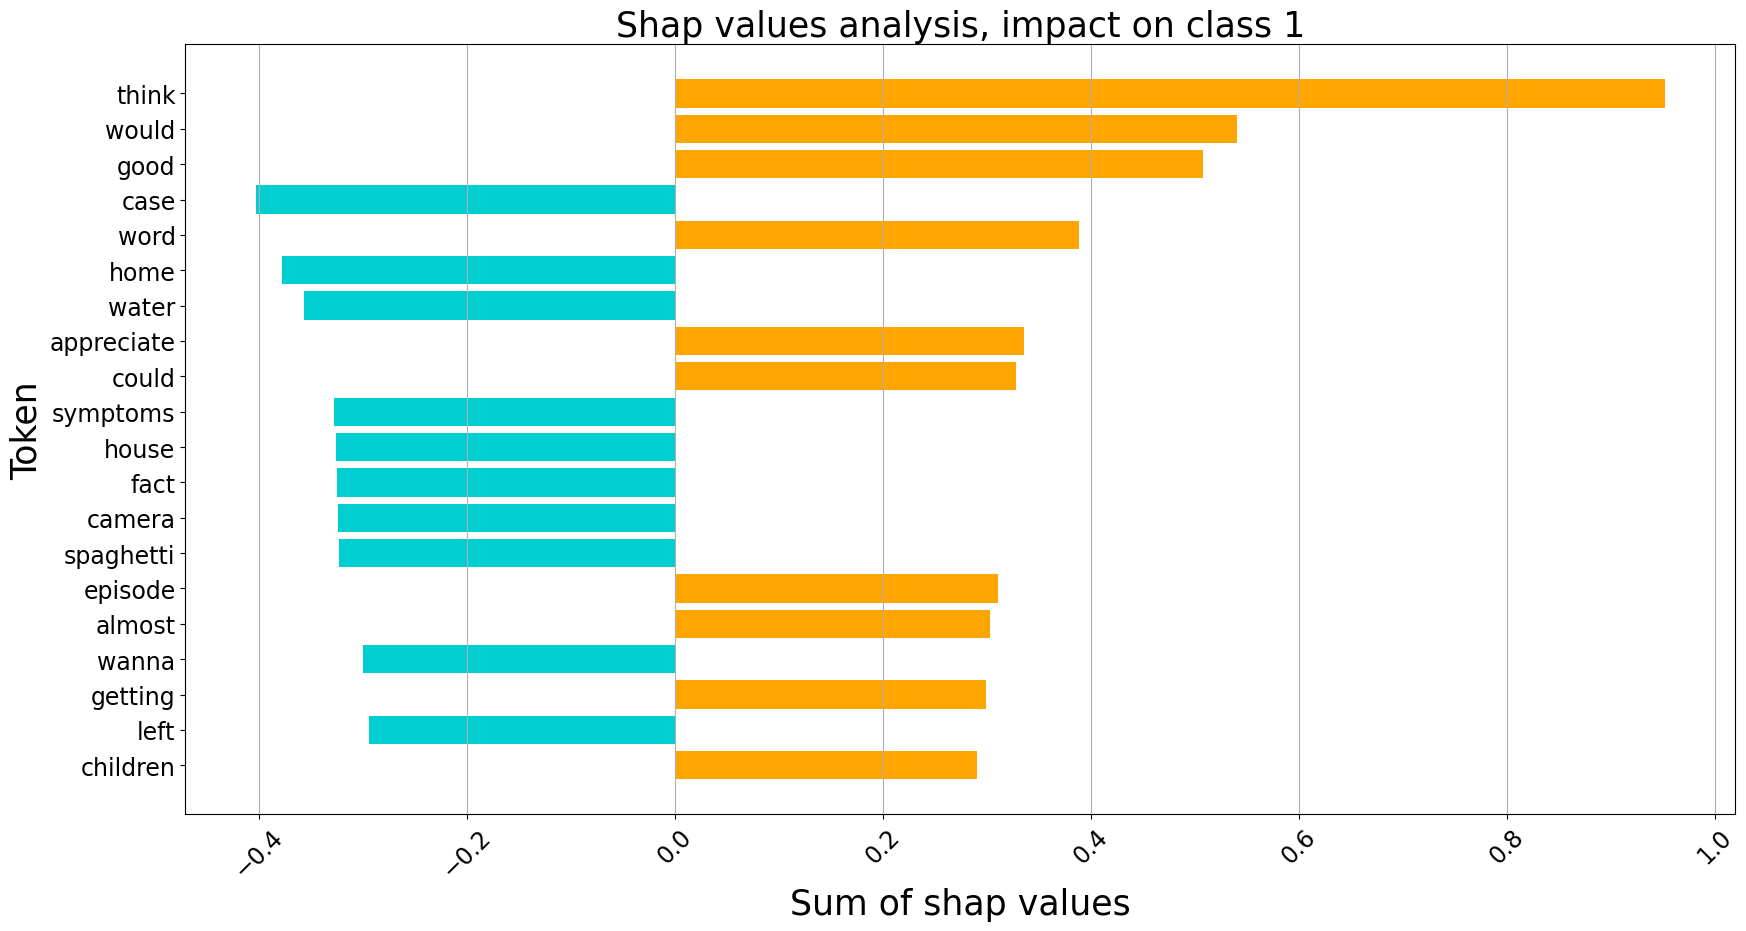

In [29]:
# IMPACT ON CLASS 1

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 1', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [2]:
# shap.plots.bar(shap_values_loaded[:,:,1].sum(0), order=shap.Explanation.argsort.flip)

In [21]:
# PLOT FOR CLASS 0

In [30]:
to_del = []
for k in sorted_d_neg.keys():
    if len(k) <= 3:
        to_del.append(k)

In [31]:
for k in to_del:
    del sorted_d_neg[k]

In [32]:
remove_keywords(sorted_d_neg)

La chiave 'foodpoisoning' non esiste nel dizionario.
La chiave 'stomachache' non esiste nel dizionario.
La chiave 'vomit' non esiste nel dizionario.
La chiave 'puke' non esiste nel dizionario.
La chiave 'the' non esiste nel dizionario.


In [33]:
to_plot_neg = get_top_n(20, sorted_d_neg)

In [34]:
colors_list = colors(to_plot_neg)

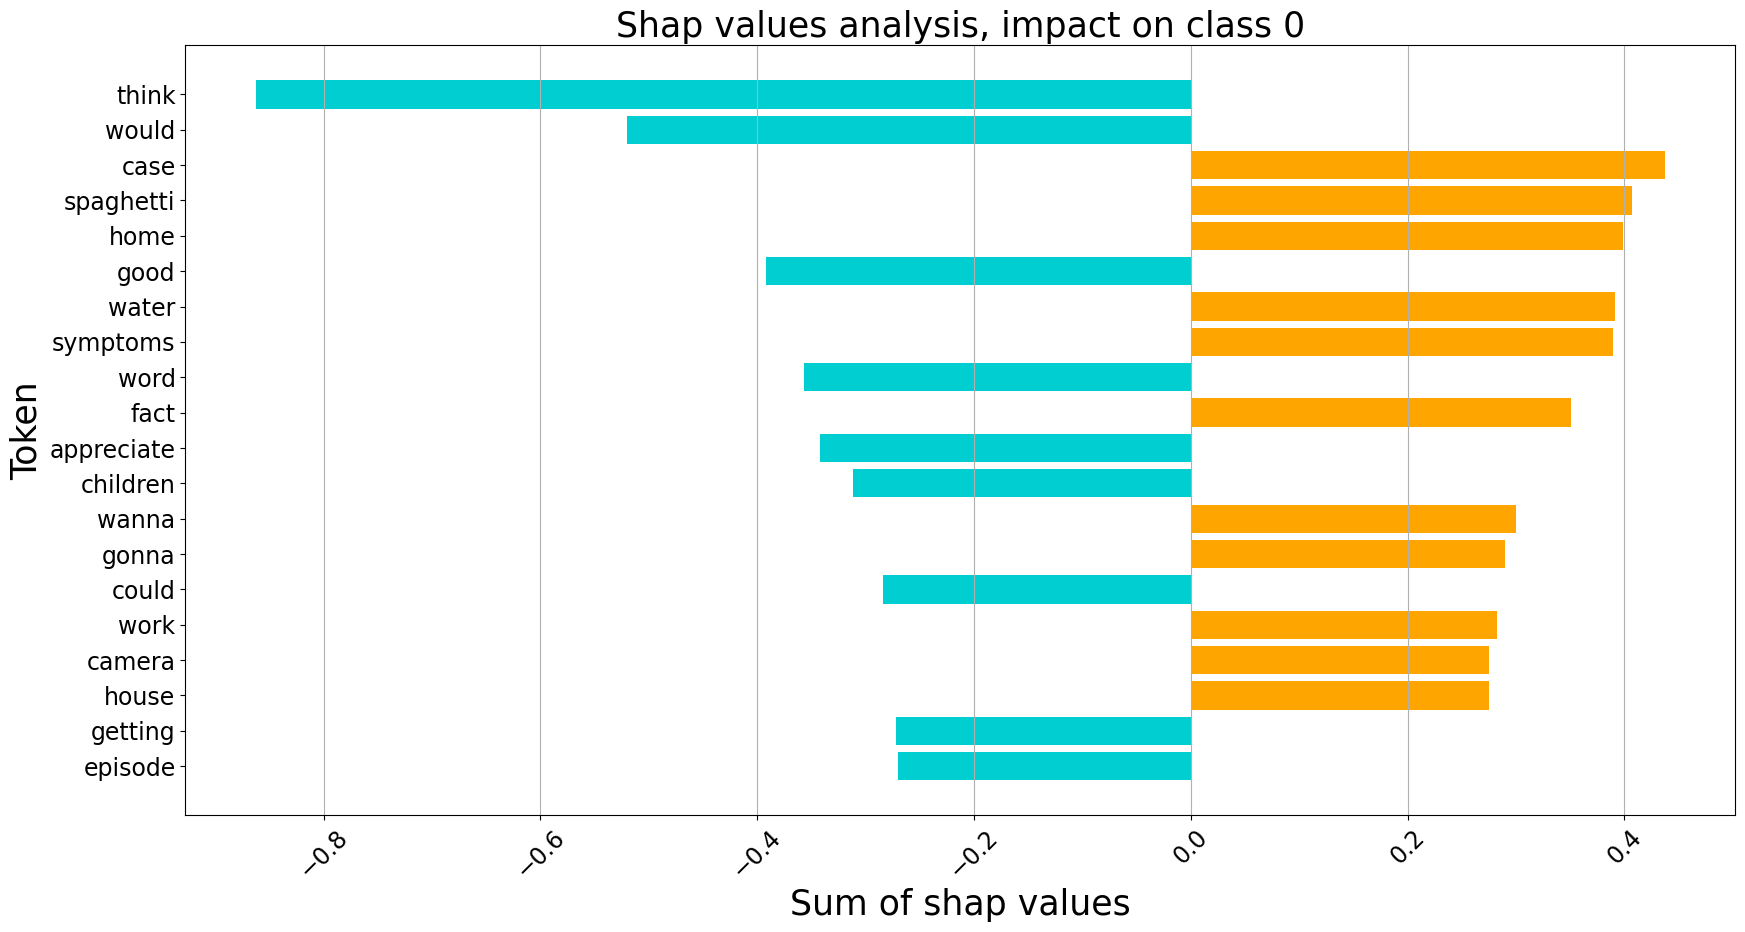

In [35]:
# IMPACT ON CLASS 0

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_neg)), list(to_plot_neg.values()), tick_label=list(to_plot_neg.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 0', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [1]:
# shap.plots.bar(shap_values_loaded[:,:,0].sum(0),  order=shap.Explanation.argsort.flip)